<a href="https://colab.research.google.com/github/AlphaMysticMac/GEN-AI/blob/main/LCEL_AND_THE_TYPES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#!pip install dotenv
#!pip install langchain_community
#!pip install docarray
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.8 MB/s eta 0:00:00


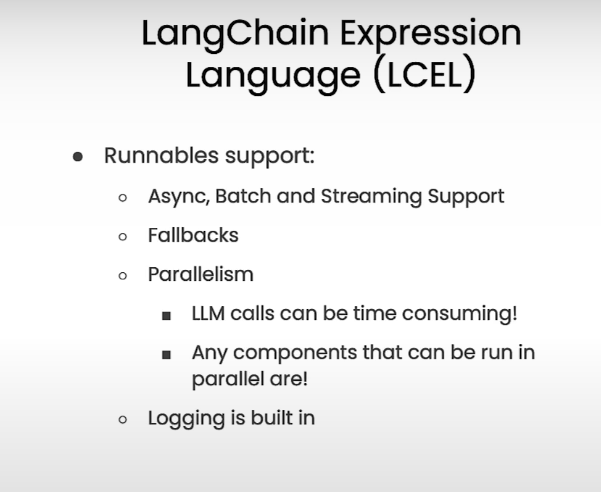

In [4]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [8]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser

In [9]:
prompt = ChatPromptTemplate.from_template(
    "Tell me about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

<ipython-input-9-36cbeec85502>:4: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI()


Simple Chain

In [11]:
chain = prompt | model | output_parser

In [12]:
chain.invoke({'topic' : 'Manchester City football club'})

"Manchester City Football Club is a professional football club based in Manchester, England. The club was founded in 1880 as St. Mark's (West Gorton) before being renamed as Ardwick Association Football Club in 1887 and finally Manchester City in 1894. \n\nManchester City is one of the most successful and popular football clubs in England, having won numerous domestic and international titles. The club has won the English Premier League title multiple times, as well as the FA Cup and the EFL Cup. Manchester City also won their first UEFA Champions League title in 2021.\n\nThe club plays their home matches at the Etihad Stadium, which has a capacity of over 53,000 spectators. The club's traditional colors are sky blue and white, and their mascot is a blue moon named Moonchester.\n\nManchester City has a strong fan base and is known for playing an attacking style of football under the management of Pep Guardiola. The club has a fierce rivalry with Manchester United, known as the Manchest

# runnable chain (complex chain)

In [13]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

In [20]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [22]:
retriever.get_relevant_documents("what did harrison work at?")

<ipython-input-22-1eba300493d0>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents("what did harrison work at?")


[Document(metadata={}, page_content='harrison worked at kensho'),
 Document(metadata={}, page_content='bears like to eat honey')]

In [23]:
template = """ Answer the relevent question based on the given context :
{context}

Question : {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [24]:
from langchain.schema.runnable import RunnableMap

In [25]:
chain = RunnableMap (
    { "context" : lambda x : retriever.get_relevant_documents(x['question']),
     "question" : lambda x : x['question']}
) | prompt | model | output_parser

In [27]:
chain.invoke({"question":"what does the bear eat?"})

'The bear eats honey.'

In [28]:
inputs = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
})

inputs.invoke({"question": "where did harrison work?"})

{'context': [Document(metadata={}, page_content='harrison worked at kensho'),
  Document(metadata={}, page_content='bears like to eat honey')],
 'question': 'where did harrison work?'}

# Function with BIND

In [29]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    },
        {
      "name": "sports_search",
      "description": "Search for news of recent sport events",
      "parameters": {
        "type": "object",
        "properties": {
          "team_name": {
            "type": "string",
            "description": "The sports team to search for"
          },
        },
        "required": ["team_name"]
      }
    }
  ]

In [37]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
model = ChatOpenAI(temperature=0).bind(functions=functions)

In [38]:
chain = prompt | model

In [39]:
chain.invoke({"input":"what is the weather like in BLR?"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"BLR"}', 'name': 'weather_search'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 100, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-c7c0f947-9395-403f-9ef7-655936ebe247-0')

In [41]:
chain.invoke({"input": "how did the patriots do yesterday?"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"team_name":"patriots"}', 'name': 'sports_search'}}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 99, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-819b473a-6eac-421d-b2b3-67db1d34bb0b-0')

# Interface

In [42]:
prompt = ChatPromptTemplate.from_template(
    "Tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

chain = prompt | model | output_parser

In [43]:
chain.invoke({"topic": "bears"})

"Why don't bears like fast food?\n\nBecause they can't catch it!"

In [44]:
chain.batch([{"topic": "bears"}, {"topic": "frogs"}])

["Why did the bear break up with his girlfriend? \n\nBecause he couldn't bear the relationship any longer!",
 'Why are frogs so happy?\n\nBecause they eat whatever bugs them!']

In [45]:
for t in chain.stream({"topic": "bears"}):
    print(t)


Why
 did
 the
 bear
 bring
 a
 flashlight
 to
 the
 party
?
 


Because
 he
 heard
 it
 was
 going
 to
 be
 a
 "
be
ary
"
 good
 time
!



In [46]:
response = await chain.ainvoke({"topic": "bears"})
response

'Why did the bear dissolve in water?\n\nBecause it was polar!'